In [ ]:
#https://creativecommons.org/licenses/by/4.0/

This file aims at creating a useful pandas-based dataframework for each subject.

## Import libraries

In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import scipy.io
import pandas as pd
from glob import glob
import os
import time
from scipy import signal
import csv

In [2]:
import pylab

Channels and sampling frequency

In [3]:
fs = 2048 #Hz, sampling frequency
n_ch = 8 #channles in one row (or column) of one set
n_ch_tot = (n_ch**2)*3 #total channels

# Data

Create dataframe

In [4]:
columns = ['task','trial',
           'set1','set2','set3',
          't_steps', 'time_duration']#,
           #'info', 'side','gain','filt_parameters','notes']
        #to add further info

#add channels as predictors

for i in range(n_ch_tot):
    columns.append('ch'+str(i+1),)

df = pd.DataFrame(columns=columns)

ch_col = df.columns[ df.columns.get_loc('ch1') : df.columns.get_loc('ch1') + n_ch_tot]

Select tasks

In [5]:
task_names = [#'iso',
              'bottle',
              'screw',
              'knife',
              'hammer',
              'peg',
              #'free_eating',
              'jar', 
              'typing']
              #'swing']

Choose subject

In [6]:
folder = '20181024_KONSENS_recordings/S2/'

Load selected tasks from chosen subject into dataframe

In [7]:
file_list = []
task_list_name = []
task_list_num = []

for task_num, task_name in enumerate(task_names):
    
    file_list_temp = glob(os.path.join(folder, '*'+task_name+'*.mat'))
    file_list.extend(file_list_temp)
    task_list_name.extend((task_name,)*np.size(file_list_temp))
    task_list_num.extend(range(np.size(file_list_temp)))
                      
for file_num, file_name in enumerate(file_list):
    print (file_name) #print loaded files
    mat = scipy.io.loadmat(file_name)
    set1_temp = np.array(mat["EMG_array"][0][0]['data'][0][0]) #first or second index? check with trial 1
    set2_temp = np.array(mat["EMG_array"][0][1]['data'][0][0])
    set3_temp = np.array(mat["EMG_array"][0][2]['data'][0][0])
        
    set1 = [] #batches to reshape data in 64 x time_steps matrices
    set2 = []
    set3 = []
        
    for i in range(n_ch):
        for j in range(n_ch):
            set1.append(np.squeeze(set1_temp[i][j]))
            set2.append(np.squeeze(set2_temp[i][j]))
            set3.append(np.squeeze(set3_temp[i][j]))
        
    df = df.append({'set1': set1, 'set2': set2, 'set3': set3,
                    't_steps': np.size(mat["EMG_array"][0][0]['data'][0][0][0][0])},
                    ignore_index=True)

df['task'] = task_list_name
df['trial'] = task_list_num

20181024_KONSENS_recordings/S2\400VrStSt181024145603_bottle1_wrong movement.mat
20181024_KONSENS_recordings/S2\400VrStSt181024145604_bottle2.mat
20181024_KONSENS_recordings/S2\400VrStSt181024145605_bottle3.mat
20181024_KONSENS_recordings/S2\400VrStSt181024145606_bottle4.mat
20181024_KONSENS_recordings/S2\400VrStSt181024145607_bottle5.mat
20181024_KONSENS_recordings/S2\400VrStSt181024145608_bottle6.mat
20181024_KONSENS_recordings/S2\400VrStSt181024145609_bottle7.mat
20181024_KONSENS_recordings/S2\400VrStSt181024145610_screw1.mat
20181024_KONSENS_recordings/S2\400VrStSt181024145611_screw2.mat
20181024_KONSENS_recordings/S2\400VrStSt181024145612_screw3.mat
20181024_KONSENS_recordings/S2\400VrStSt181024145613_screw4.mat
20181024_KONSENS_recordings/S2\400VrStSt181024145614_screw5.mat
20181024_KONSENS_recordings/S2\400VrStSt181024145615_knife1.mat
20181024_KONSENS_recordings/S2\400VrStSt181024145616_knife2.mat
20181024_KONSENS_recordings/S2\400VrStSt181024145617_knife3.mat
20181024_KONSENS_r

In [8]:
#df = df.drop(df.index[[0]])

Add time duration in seconds

In [9]:
df['time_duration'] = (df['t_steps']/fs).astype(int)

Adding single channels as columns

In [10]:
df['set'] = df[['set1','set2','set3']].apply(lambda x: np.concatenate(x),axis=1)
df[ch_col.tolist()] = [df['set'][trialN].tolist() for trialN in df.index]

# Examples to index data

In [ ]:
df

Example to locate knife trials on original dataframe:

In [ ]:
df[df.task=='bottle']

Locate total trials in knife task, and refer to specific trial index:

In [ ]:
print (np.size(df[df.task=='knife'].trial))
df[df.task=='bottle'].trial.iloc[0] #trial 1 in knife

Locate 8x8 recordings for specific task and set across trials:

In [ ]:
TASK_NAME = 'bottle'
setN = 'set1'
trialN = 3
channelN = 54
df[df.task==TASK_NAME][setN][trialN][channelN]

Plot signal

In [ ]:
trace = df[df.task==TASK_NAME][setN][trialN][channelN]
time = np.linspace(0, round(np.size(trace)/fs), np.size(trace))

ax = plt.figure
plt.plot(time, trace, color='k')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV)')
plt.show()

Alternatively

In [ ]:
TASK_NAME = 'bottle'
trialN = 4
channelN = 'ch160'
df[df.task==TASK_NAME][channelN].iloc[trialN]

trace = df[df.task==TASK_NAME][channelN].iloc[trialN]
time = np.linspace(0, round(np.size(trace)/fs), np.size(trace))

ax = plt.figure
plt.plot(time, trace, color='k')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV)')
plt.show()

Time-step duration

In [ ]:
#in bottle task, trial 3
print (df[df.task=='bottle'].t_steps.iloc[2])
print (df[df.task=='bottle']['t_steps'][3]) #index change

# Plot trials

### Layout reflecting electrode array disposition

In [ ]:
trialN = 0

y_lim = df[ch_col].loc[trialN].apply( lambda x: max(x) ).max()

plt.figure(figsize=(12, 10))

for ch in range(n_ch**2):
        
        channelN = 'ch'+str(ch+1)
        ax = plt.subplot(n_ch,n_ch,ch+1)
        ax.plot(df[channelN].loc[trialN],
                color='k',
                linewidth=.5)
        ax.set_axis_off()
        ax.set_title(ch+1)
        ax.set_ylim([0, y_lim])
plt.tight_layout
plt.show()


plt.figure(figsize=(12, 10))

#for ch in range((n_ch**2),2*(n_ch**2)):
for ch in range(n_ch**2):
        
        channelN = 'ch'+str(ch+1+(n_ch**2))
        ax = plt.subplot(n_ch,n_ch,ch+1)
        ax.plot(df[channelN].loc[trialN],
                color='b',
                linewidth=.5)
        ax.set_axis_off()
        ax.set_title(ch+1+(n_ch**2))
        ax.set_ylim([0, y_lim])
plt.tight_layout
plt.show()


plt.figure(figsize=(12, 10))

#for ch in range(2*(n_ch**2), n_ch_tot):
for ch in range(n_ch**2):
        
        channelN = 'ch'+str(ch+1+2*(n_ch**2))
        ax = plt.subplot(n_ch,n_ch,ch+1)
        ax.plot(df[channelN].loc[trialN],
                color='r',
                linewidth=.5)
        ax.set_axis_off()
        ax.set_title(ch+1+2*(n_ch**2))
        ax.set_ylim([0, y_lim]) #max of 64
        
plt.tight_layout
plt.show()

# Inspect traces (channels with artifacts for each trial)

## Manual list

By plotting traces trial by trial (see 'Plot trials')

In [ ]:
chN_del = [
[1, 2, 9, 5, 6, 7, 14, 15, 17, 33, 73, 74, 81, 82, 89, 137], #trial_0 #list.extend(range(145, 163))
[1, 2, 73, 74, 81, 82, 89 ], #trial_1
[150, 151], #trial_2
[2, 137], #trial_3
[ ], #trial_4
[154, 155], #trial_5
[ ], #trial_6
[156, 157], #trial_7
[ ], #trial_8
[2, 137, 147, 148, 149, 150, 151, 154, 155, 156, 157, 158, 159, 160, 161, 162], #trial_9
[ ], #trial_10
[ ], #trial_11
[ ], #trial_12
[ ], #trial_13
[ ], #trial_14
[158, 159], #trial_15
[ ], #trial_16
[ ], #trial_17
[ ], #trial_18
[ ], #trial_19
[ ], #trial_20
[ ], #trial_21
[ ], #trial_22
[ ], #trial_23
[ ], #trial_24
[ ], #trial_25
[ ], #trial_26
[ ], #trial_27
[ ], #trial_28
[ ], #trial_29
[ ], #trial_30
[ ], #trial_31
[ ], #trial_32
[ ], #trial_33
[2, 137, 147, 148, 149], #trial_34
]

Save faulty traces per trial in dataframes

In [ ]:
df['chN_del'] = [chN_del[trialN] for trialN in df.index] # number of bad channels - integers (from manual list)
ch_del = [['ch'+str(i) for i in df['chN_del'][trialN]] for trialN in df.index] # bad channels - strings
df['ch_del'] = ch_del

Dataframe with 0s and 1s for bad and good channels

In [ ]:
df_ch = pd.DataFrame(1, columns=ch_col, index=df.index)
for trialN in df.index:
    df_ch.at[trialN, ch_del[trialN]] = [0 for i in ch_del[trialN]] # 0-ing boxes for bad channels

## Semi-automated lists

### 1) Trace exceeds v% of max(V) for P% of time of a given trial

In [11]:
P = .01 # normalised 0 to 1
v = .1 # normalised 0 to 1

Compute max(V) values for each trial and plot distribution of such limits

In [12]:
y_lim = [df[ch_col].loc[trialN].apply( lambda x: max(x) ).max() for trialN in df.index] #find max values per trial

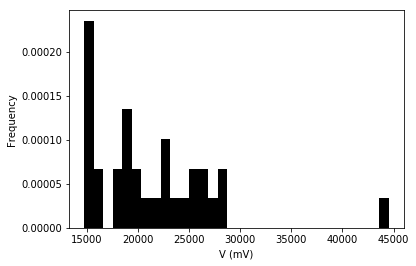

In [13]:
counts = plt.hist(y_lim, bins=len(df.index), density=True, color='k')
plt.xlabel('V (mV)')
plt.ylabel('Frequency')
plt.show()

Compute dataframe with sums of exceeding times and save it as file (this is time-consuming, see saved files)

In [14]:
#ch_list = []
#s = []

#for trialN in df.index:
#    s.append([sum(abs(np.array(df[ch][trialN]))>=y_lim[trialN]*v) for ch in ch_col])

#S = pd.DataFrame(s)
#S.to_csv(folder+'s_10')

Load saved file

In [15]:
S = pd.read_csv(folder+'s_'+str(int(v*100)), index_col=0)

Compute which traces exceed voltage for enough time

In [16]:
df_ch_list = [S.loc[trialN].apply( lambda x: x>(P*df['t_steps'][trialN]) ) for trialN in df.index]

### 2) First derivative

In [ ]:
s = 0
plt.figure()
for trialN in range(1): #df.index:
    for ch in ch_col:
        der = abs(np.array(df[ch][trialN][1:]))-abs(np.array(df[ch][trialN][0:-1]))
        s = s+(sum(der>1000)>=1)
        plt.plot(der)
plt.ylim([0, 3000])        
plt.show()

In [ ]:
s

### 3) Trace exceeds P% of time over mean + n times SD

Add mean and SD over time for each channel trace, as columns

In [ ]:
for i in range(n_ch_tot):
    df[ch_col[i]+'_mean'] = df[ch_col[i]].map(lambda x: np.array(x).mean())
    df[ch_col[i]+'_std'] = df[ch_col[i]].map(lambda x: np.array(x).std())

In [ ]:
P = .01
n = 4
df['artifacts'] = np.nan #artifacts
df['artifacts'] = df['artifacts'].astype(object)

for trialN in df.index:
    ch_list = []
    
    for chN, ch in enumerate(ch_col):
        s = (abs(np.array(df[ch][trialN]))>=df[ch+'_mean'][trialN]+n*df[ch+'_std'][trialN]).sum()
        
        if s > P*df['t_steps'][trialN]:
            ch_list.append(chN)
    
    df.at[trialN, 'artifacts'] = ch_list

In [ ]:
df['artifacts']

## Automated: convert list into dataframe with 0-1s for good-faulty traces

In [25]:
df_ch = pd.DataFrame(df_ch_list) # list into dataframe
chN_del = [np.nonzero(df_ch_list[trialN])[0].tolist() for trialN in df.index] # drop zeros to keep channel indeces
df_ch.columns = ch_col

Save faulty traces per trial in dataframes

In [26]:
df['chN_del'] = chN_del # number of bad channels - integers
df['ch_del'] = [['ch'+str(i) for i in df['chN_del'][trialN]] for trialN in df.index] # bad channels - strings
df_ch['ch_del'] = df['ch_del'].copy()
df_ch['chN_del'] = df['chN_del'].copy()

## Regardless of manual or automated method

#### Examples

In [27]:
df_ch.sum(axis=0).values # number of faulty traces across channel number
df_ch.sum(axis=1).values # number of faulty traces across trial number

array([ 7,  2, 13,  4, 25,  8,  2, 19,  4, 13, 17,  9, 15, 15, 13, 13,  9,
        8,  9,  7, 11,  2, 16, 13, 15, 12, 17, 18, 13, 18,  7, 10],
      dtype=int64)

### Analyse most frequently faulty channels

Create merged list of channels from all trials for plotting distribution

In [28]:
chN_del_list = []
for i in chN_del:
    chN_del_list += i
print ('Total traces to be potentially discarded:',
       len(chN_del_list),'/',n_ch_tot*len(df.index),'=',
       len(chN_del_list)/(n_ch_tot*len(df.index))*100,'%')

Total traces to be potentially discarded: 364 / 6144 = 5.924479166666666 %


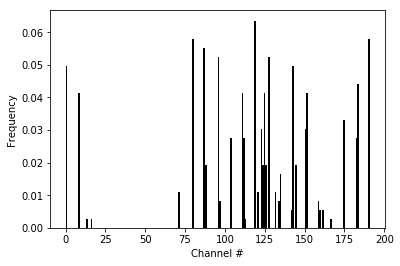

In [29]:
counts = plt.hist(chN_del_list, bins=n_ch_tot, density=True, color='k')
plt.xlabel('Channel #')
plt.ylabel('Frequency')
plt.show()

# Clean dataframe

In [30]:
df_copy = df.copy()
#df_copy.to_csv(folder+'df_copy') # save copy before cleaning: this is time-consuming, uncomment only if needed

In [31]:
df = df.drop(['set1', 'set2', 'set3','set'], axis=1) # drop redundant data

### Deleting trace for faulty traces

In [32]:
df[ch_col] = df_ch[ch_col]*df[ch_col]
#df.to_csv(folder+'df_clean') # save file with clean dataframe: this is time-consuming, uncomment only if needed
df_ch.to_csv(folder+'df_ch') # save file with 0-1s dataframe

### Single files with bad channels for each trial

In [33]:
file_list_ch_del = [file_list[trialN].replace('.mat', '_ch.csv') for trialN in df.index]

for trialN, file_name in enumerate(file_list_ch_del):
    df_ch.loc[[trialN]].to_csv(file_name)

Example to call file

In [34]:
df_read = pd.read_csv(file_name, index_col=0)
df_read
#df_read.iloc[0] #first row

,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8,ch9,ch10,...,ch185,ch186,ch187,ch188,ch189,ch190,ch191,ch192,ch_del,chN_del
31,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,"['ch80', 'ch87', 'ch111', 'ch119', 'ch125', 'c...","[80, 87, 111, 119, 125, 135, 143, 151, 175, 183]"


# Time-frequency decomposition

In [ ]:
#low Tukey parameter
TASK_NAME = 'knife'
trialN = 3
channelN = 'ch10'

x = np.array(df[df.task==TASK_NAME][channelN].iloc[trialN])
#x = np.array(df[df.task==TASK_NAME][channelN].iloc[trialN])
x = x - x.mean() # delete mean signal

f, t, Sxx = signal.spectrogram(x, fs, window=('tukey', 0.001))

plt.figure(figsize=(8, 4))
plt.pcolormesh(t, f, Sxx)
plt.ylabel('Frequency [Hz]')
plt.ylim([20,200])
plt.show()

In [ ]:
#high Tukey parameter
f, t, Sxx = signal.spectrogram(x, fs, window=('tukey', 1))

plt.figure(figsize=(8, 4))
plt.pcolormesh(t, f, Sxx)
plt.ylabel('Frequency [Hz]')
plt.ylim([20,200])
plt.show()

In [ ]:
# look for best time-frequency resolution

In [ ]:
p = []
for i in range(1,10000):
    f, t, Sxx = signal.spectrogram(x, fs, window=('tukey', 0.001), nperseg=int(len(x)/i))
    p.append(np.size(Sxx))

In [ ]:
plt.figure(figsize=(10,3))
ax = plt.subplot(121)
ax.plot(p)
ax.set_ylabel('Matrix size')
ax.set_xlim([0, 4000])

i = 500

ax = plt.subplot(122)
f, t, Sxx = signal.spectrogram(x, fs, window=('tukey', 1), nperseg=int(len(x)/i))
ax.pcolormesh(t, f, Sxx)
ax.set_xlabel('Time')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

same length for different signals (e.g. 100-150 ms)

In [ ]:
f

In [ ]:
TASK_NAME = 'typing'
trialN = 3
channelN = 'ch9'

x = np.array(df[df.task==TASK_NAME][channelN].iloc[trialN])
#x = np.array(df[df.task==TASK_NAME][channelN].iloc[trialN])
#x = x - x.mean() # delete mean signal

f, t, Sxx = signal.spectrogram(x, fs)

plt.figure(figsize=(18, 2))
ax = plt.subplot(131)
plt.pcolormesh(t, f, Sxx)
ax.set_ylabel('Frequency [Hz]')

ax = plt.subplot(132)
plt.pcolormesh(t, f, Sxx, cmap='hot')
ax.set_ylim([40,200])
#ax.set_xlim([6,8])
plt.colorbar()

ax = plt.subplot(133)
plt.pcolormesh(t, f, Sxx, cmap='binary')

plt.xlabel('Time [sec]')
plt.show()

In [ ]:
# different plotting, with 10 log_10 scale
f, t, Sxx = signal.spectrogram(x, fs)

plt.figure(figsize=(18, 2))
ax = plt.subplot(131)
plt.pcolormesh(t, f, 10*np.log10(Sxx))
ax.set_ylabel('Frequency [Hz]')
plt.colorbar()

ax = plt.subplot(132)
plt.pcolormesh(t, f, 10*np.log10(Sxx), cmap='hot')
ax.set_ylim([40,350])
ax.set_xlim([6,8])
#plt.colorbar()

ax = plt.subplot(133)
plt.pcolormesh(t, f, 10*np.log10(Sxx), cmap='binary')

plt.xlabel('Time [sec]')
plt.show()

In [ ]:
#different package: specgram, plots directly, using 10 log_10 scale

In [ ]:
#NFFT = 128
Fs = fs
#noverlap = 

#NFFT = int(Fs*0.05)
#noverlap = int(Fs*0.00000001)

NFFT = 259
noverlap = 129

pylab.figure(1)
pylab.specgram(x, NFFT=NFFT, Fs=Fs/2, noverlap=noverlap, cmap='hot')
plt.colorbar()
plt.show()

In [ ]:
# try different task, and removing the mean signal

In [ ]:
TASK_NAME = 'screw'
trialN = 4
channelN = 'ch10'

x = np.array(df[df.task==TASK_NAME][channelN].iloc[trialN])
x = x - x.mean()

In [ ]:
Pxx, freqs, bins, im = plt.specgram(x, NFFT=int(1028/2), Fs=fs)
plt.colorbar()
plt.show()

Compare trials over channels for one task (within subject)

In [ ]:
TASK_NAME = 'knife'
trialN_tot = np.size(df[df.task==TASK_NAME],0)

plt.figure(figsize=(16, 16))
 
#for ch in range(n_ch_tot): #each channel, rows
for ch in range(n_ch**2): #each channel, rows
    for trialN in range(trialN_tot): #each trial, columns
        
        ax = plt.subplot(n_ch**2, trialN_tot, trialN_tot*ch+trialN+1)
        #ax = plt.subplot(192, 5, 5*ch+trialN+1 )
        #ax = plt.subplot((n_ch_tot,np.size(df[df.task==TASK_NAME],0),trialN_tot*ch+trialN+1)
        
        channelN = 'ch'+str(ch+1)
        x = np.array(df[df.task==TASK_NAME][channelN].iloc[trialN])
        f, t, Sxx = signal.spectrogram(x, fs)
        ax.pcolormesh(t, f, Sxx, cmap='hot')
        ax.set_ylim([0, 300])
        
        if trialN == 0:
            ax.set_ylabel('ch'+str(ch+1))
            
        if ch == 0:
            ax.set_title('Trial #'+str(trialN+1))
        
        #ax.set_axis_off()
plt.tight_layout
plt.show()

It would be better to split on more columns, on a larger window.

Prediction with just action onset?

All matrix

In [ ]:
trialN_tot = len(df.index)

Th = .05 # threshold
t_W = 5
f_W = 16

time_dim = np.zeros((n_ch_tot, trialN_tot, t_W))
freq_dim = np.zeros((trialN_tot, n_ch_tot))

p_tot = f_W*t_W*n_ch_tot

df['pred'] = ''

for w in range(p_tot):
    df['p'+str(w)] = ''

for trialN in df.index: #each trial, columns
    
    F = []
    
    for chN, ch in enumerate(ch_col): #each channel, rows

        x = np.array(df[ch].loc[trialN])
        
        #if np.isnan(x[0])==False:
        if x.size > 0:
            f, t, Sxx = signal.spectrogram(x, fs)
        
            ind = np.where(Sxx/np.max(Sxx) > Th) #5% threshold
            time_dim[chN, trialN, :] = np.unique(ind[0])[0:t_W]
            
            freq_dim[trialN, chN] = np.argmax(np.sum(Sxx[:, time_dim[chN,trialN,:].astype(int)], axis=1))
            W = np.reshape(Sxx[0:f_W, time_dim[chN,trialN,:].astype(int)], (t_W*f_W)) #time-frequency window of interest
            F.append(W)
        else:
            W = (np.nan,)*(t_W*f_W) #time-frequency window of interest
            F.append(W)
    
    #df['pred'].loc[trialN] = np.reshape(F, p_tot)
    df.at[trialN, 'pred']= np.reshape(F, p_tot)

df['freq'] = freq_dim.tolist()

A column for each t-f pixel

In [ ]:
p_col = df.columns[ df.columns.get_loc('p0') : df.columns.get_loc('p0') + p_tot]

In [ ]:
df[p_col] = df['pred'].tolist()

Set ticks for heat map

In [ ]:
yticks = []
yticks.append(np.size(df[df.task==task_names[0]].trial)/2)

for i in range(1, len(task_names)):
    yticks.append(np.size(df[df.task==task_names[i]].trial)/2+np.size(df[df.task==task_names[i-1]].trial)/2+yticks[i-1])

Plot heat map

In [ ]:
plt.figure(figsize=(16,40))
ax = plt.gca()

im = ax.imshow(freq_dim, interpolation='nearest', cmap=cm.jet, vmax=freq_dim.max(), vmin=0)
#im = ax.imshow(freq_dim, interpolation='nearest', cmap=cm.jet, vmax=10, vmin=0)

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

ax.set_yticks(yticks)
ax.set_yticklabels(task_names)

plt.colorbar(im, cax=cax)
plt.ylabel('Frequency (Hz)')
ax.set_xlabel('channel #')
ax.set_ylabel('trial #')
ax.set_title('Frequency with greatest contribution')
plt.show()

- check time-frequency resolution in spectrogram (check time length from spectogram properties)
- create time-frequency window
- reshape it into array for prediction

## Classifiers

In [ ]:
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler  
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [ ]:
predictors=p_col

In [ ]:
X = df[predictors].fillna(0, inplace=False)
y = df['task']

In [ ]:
X

In [ ]:
y

Use imputer from sklearn

In [ ]:
#SVM = sklearn.svm.SVC(kernel='rbf')
#SVM.fit(X, y)  
#SVM.score(X,y)

rfc = RandomForestClassifier()
rfc.fit(X, y)
rfc.score(X,y)

In [ ]:
#scoreSVM=([]);
scoreRFC=([]);

In [ ]:
kf = KFold(n_splits=5) 
#KFold(n_splits=2, random_state=None, shuffle=False)

In [ ]:
for train,test in kf.split(X):
    
    ## SVM
    #SVM =  sklearn.svm.SVC(kernel='rbf')
    #SVM.fit(X.iloc[train],y.iloc[train])
    #scoreSVM.append(SVM.score(X.iloc[test], y.iloc[test])) #accuracy
    
    ## RFC
    RFC =  RandomForestClassifier()
    RFC.fit(X.iloc[train],y.iloc[train])
    scoreRFC.append(RFC.score(X.iloc[test], y.iloc[test])) #accuracy

In [ ]:
#print (np.mean(scoreSVM))
#print (np.std(scoreSVM))
#print ()
print (np.mean(scoreRFC))
print (np.std(scoreRFC))
print ('chance line=', 1/len(task_names))

With NaN, after artefact pre-processing

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Imputer

X_train = [[0, 0, np.nan], [np.nan, 1, 1]]
Y_train = [0, 1]
X_test_1 = [0, 0, np.nan]
X_test_2 = [0, np.nan, np.nan]
X_test_3 = [np.nan, 1, 1]

# Create our imputer to replace missing values with the mean e.g.
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp = imp.fit(X_train)

# Impute our data, then train
X_train_imp = imp.transform(X_train)
clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(X_train_imp, Y_train)

for X_test in [X_test_1, X_test_2, X_test_3]:
    # Impute each test item, then predict
    X_test_imp = imp.transform(X_test)
    print(X_test, '->', clf.predict(X_test_imp))

In [ ]:
np.shape(y_test)

In [ ]:
# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

h = .02  # step size in the mesh

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets

# preprocess dataset, split into training and test part
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=.4, random_state=42)

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# just plot the dataset first
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])


# iterate over classifiers
for name, clf in zip(names, classifiers):
    
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors='k')

    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors='k')
    
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, edgecolors='k', alpha=0.6)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    
    ax.set_title(name)
    ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'), size=15, horizontalalignment='right')
    i += 1

plt.tight_layout()
plt.show()

In [ ]:
# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

X = df[predictors].fillna(0, inplace=False)
y = df['task']

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=2),
    #RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
    RandomForestClassifier(),
    #MLPClassifier(alpha=10),
    MLPClassifier(hidden_layer_sizes=(10)),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

# preprocess dataset, split into training and test part
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=.4, random_state=42)

# iterate over classifiers
for name, clf in zip(names, classifiers):
    
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)

    print (name)
    print (score)
    print ()